In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install import_ipynb 
!conda install -c conda-forge import_ipynb

/Users/gabesmithline/miniconda3/lib/python3.10/site-packages/conda/base/context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Retrieving notices: done
Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - import_ipynb

Current channels:

  - https://conda.anaconda.org/conda-forge
  - defaults
  - https://conda.anaconda.org/pytorch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org



In [3]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from prompts.make_prompt_bargain import make_prompt_bargain
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

pathology_results = pd.DataFrame()  

envy_results_history = {}

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-h2vy84lx because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

In [4]:
def calculate_discounted_value(offer, values, gamma, round_num):
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [5]:

import time
prompt_style = 'llama_3.3_70b_maximize_value_outside_offer_cot_1'
#prompt_style = 'openai_4o_maximize_value_outside_offer_cot_.8'
# prompt_style = 'bargain_maximize_results_outside_offer_emphasized_with_example'
#prompt_style = 'anthropic_3_opus_maximize_value_outside_offer_cot_1' #claude sonnet is the model
#prompt_style = 'gemini_2.0_flash_maximize_value_outside_offer_cot_.8'
date = '1_6_2025'
max_rounds = 3

def calculate_discounted_value(offer, values, gamma, realization_round):
    
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (realization_round - 1))

rounds = []
p1_values = []
p2_values = []
games = 100  

pathology_results = pd.DataFrame()
envy_results_history = {}

for i in range(games):
    if (i + 1) % 10 == 0:
        print(f"Game {i + 1} of {games}")
        time.sleep(2 * 60)  #Sleep for 2 minutes

    rounds = []
    p1_values = []
    p2_values = []
    p1_offers = []
    p2_offers = []

    game = NegotitaionGame(
        player1_agent=llm_agent.LLMAgent(player_num=0),
        player2_agent=llm_agent.LLMAgent(player_num=1),
        num_items=5,
        item_value_range=[1, 101], 
        gamma=0.9,
        max_rounds=max_rounds,
    ) 

    game_history = GameHistory(
        agent_1_name="Agent1",
        agent_2_name="Agent2",
        num_items=game.num_items,
        items=torch.tensor(game.items),
        agent_1_values=torch.tensor(game.player_values[0]),
        agent_2_values=torch.tensor(game.player_values[1]),
        agent_1_outside_value=game.outside_offer_values[0],
        agent_2_outside_value=game.outside_offer_values[1]
    )

    game_history.agent_1_offers = []
    game_history.agent_2_offers = []

    game.game_results = pd.DataFrame(columns=[  
        "game_num", "round_num", "player", "discount_rate", "offer", "value", "items",
        "your_side_of_current_offer", "outside_offer", "accepting_an_offer_worse_than_outside_offer",
        "making_an_offer_worse_for_you_than_your_outside_offer",
        "walking_away_from_an_offer_better_than_your_outside_offer",
        "offer_no_items_or_all_items", "making_offer_worse_than_previous"
    ])

    while game.in_progress:
        time.sleep(5) #Sleep for 5 seconds before taking a step
        current_step = len(game.history[0]) + len(game.history[1]) + 1
        current_round = (current_step - 1) // 2 + 1
        current_player = 1 if current_step % 2 == 1 else 2
        game.current_round = current_round
        your_side_of_current_offer = None
        '''
        PATHOLOGIES
        '''
        making_offer_worse_than_previous = False  #Only occurs in non-final rounds
        making_offer_worse_than_outside_offer = False  #Only occurs in non-final rounds
        offer_no_items_or_all_items = False  #Only occurs in non-final rounds
        accepting_an_offer_worse_than_outside_offer = False  #Only occurs in final round
        walking_away_from_an_offer_better_than_outside_offer = False  #Only occurs in final round

        print(f"\n{'=' * 80}")
        print(f"Game {i + 1}, Round {current_round}, Player {current_player}'s turn (Step {current_step})")
        print(f"{'=' * 80}")

        prev_offer = game.current_offer
        game.step()

        if game.current_offer: 

            if game.players[current_player - 1].action == "COUNTEROFFER":
                if current_player == 1:
                    realization_round_p1 = current_round
                    realization_round_p2 = current_round
                else:
                    realization_round_p1 = current_round + 1
                    realization_round_p2 = current_round + 1 
            else: #realization round is the current round
                realization_round_p1 = current_round
                realization_round_p2 = current_round

            #calculate values with realization rounds
            # Corrected value calculations
            if current_player == 1 and game.players[current_player - 1].action == "COUNTEROFFER": #TODO: CAN REMOVE EXTRA COUNTEROFFER CONDITION
                p1_kept = game.items - np.array(game.current_offer.offer)
                p2_kept = np.array(game.current_offer.offer)
            elif current_player == 2 and game.players[current_player - 1].action == "COUNTEROFFER": #TODO: CAN REMOVE EXTRA COUNTEROFFER CONDITION 
                p1_kept = np.array(game.current_offer.offer)
                p2_kept = game.items - np.array(game.current_offer.offer)

            p1_value = calculate_discounted_value(
                p1_kept, game.player_values[0], game.gamma, realization_round_p1
            )
            p2_value = calculate_discounted_value(
                p2_kept, game.player_values[1], game.gamma, realization_round_p2
            )

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            if current_player == 1:
                p1_offers.append(game.current_offer.offer)
            else:
                p2_offers.append(game.current_offer.offer)
                print(f"\nRound {current_round} Values:")
                print(f"Player 1: {p1_value:.2f}")
                print(f"Player 2: {p2_value:.2f}")

            '''
            PATHOLOGY 1: Immediate offer was worse than the offer you just rejected
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (game.current_round == 1 and current_player == 2) or game.current_round > 1:
                    if current_player == 1:
                        your_side_of_previous_offer = p1_values[-2]  #P1's value from P2's previous offer
                        your_side_of_current_offer = p1_values[-1]  #P1's value from the current offer
                    else:
                        your_side_of_previous_offer = p2_values[-2]  #P2's value from P1's previous offer
                        your_side_of_current_offer = p2_values[-1]  #P2's value from the current offer

                    if your_side_of_previous_offer > your_side_of_current_offer:
                        making_offer_worse_than_previous = True
                    else:
                        making_offer_worse_than_previous = False

                '''
                PATHOLOGY 2: Immediate offer was worse than your outside offer
                '''
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** current_round) #discounted outside offer at next round
                    if p2_value < outside_offer:
                        making_offer_worse_than_outside_offer = True
                    else:
                        making_offer_worse_than_outside_offer = False
            else:
                making_offer_worse_than_outside_offer = False

            '''
            PATHOLOGY 3: Offer had no items or all items
            '''
            if game.players[current_player - 1].action == "COUNTEROFFER":
                if (np.array_equal(game.current_offer.offer, [0] * game.num_items) or
                        np.array_equal(game.current_offer.offer, game.items)):
                    offer_no_items_or_all_items = True
                else:
                    offer_no_items_or_all_items = False

            '''
            PATHOLOGY 4: Accepting an offer worse than your outside offer
            '''
            if game.final_action_player.action == "ACCEPT":
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value < outside_offer:
                        accepting_an_offer_worse_than_outside_offer = True

            '''
            PATHOLOGY 5: Walking away from an offer better than your outside offer
            '''
            if game.final_action_player.action == "WALK" or (
                    current_player == 2 and
                    game.players[current_player - 1].action == "COUNTEROFFER" and
                    game.current_round == game.max_rounds):
                if current_player == 1:
                    outside_offer = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                    if p1_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True
                elif current_player == 2:
                    outside_offer = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                    if p2_value > outside_offer:
                        walking_away_from_an_offer_better_than_outside_offer = True

            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": game.current_offer.offer,
                "value": p1_value if current_player == 1 else p2_value,
                "items": game.items,
                "your_side_of_current_offer": your_side_of_current_offer,
                "outside_offer": outside_offer,
                "accepting_an_offer_worse_than_outside_offer": accepting_an_offer_worse_than_outside_offer,
                "making_an_offer_worse_for_you_than_your_outside_offer": making_offer_worse_than_outside_offer,
                "walking_away_from_an_offer_better_than_your_outside_offer": walking_away_from_an_offer_better_than_outside_offer,
                "offer_no_items_or_all_items": offer_no_items_or_all_items,
                "making_offer_worse_than_previous": making_offer_worse_than_previous
            }])], ignore_index=True)

        '''
        FINAL POSSIBLE ROUND PRINT STATEMENTS
        '''
        if game.current_offer is not None and len(game.current_offer.offer) == game.num_items:
            
            game_history.add_offer(
                game.current_player,
                Offer(game.current_player, offer=torch.tensor(game.current_offer.offer))
            )

        if current_round == game.max_rounds and current_player == 2:
            if game.current_offer and game.current_offer != prev_offer:
                print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")
            elif game.current_offer == prev_offer:
                print("\nPlayer 2's final action: ACCEPT")
                p1_kept = game.items - np.array(game.current_offer.offer)
                p1_value = calculate_discounted_value(
                    p1_kept, game.player_values[0], game.gamma, current_round
                )
                p2_value = calculate_discounted_value(
                    game.current_offer.offer, game.player_values[1], game.gamma, current_round
                )
            else:
                
                print("\nPlayer 2's final action: WALK")
                p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
                p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
                print("\nGame ended after max rounds - both players get outside offers")

            game.in_progress = False
            print(f"\nRound {current_round} Final Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")

            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            break
        elif game.current_offer is None and current_player == 1 and game.final_action_player.action == "WALK":
            # If Player 1 makes an invalid offer
            game.game_results = pd.concat([game.game_results, pd.DataFrame([{
                "game_num": i,
                "round_num": current_round,
                "player": current_player,
                "discount_rate": game.gamma ** (current_round - 1),
                "offer": [],
                "value": None,
                "items": game.items,
                "your_side_of_current_offer": None,
                "outside_offer": None,
                "accepting_an_offer_worse_than_outside_offer": None,
                "making_an_offer_worse_for_you_than_your_outside_offer": None,
                "walking_away_from_an_offer_better_than_your_outside_offer": None,
                "offer_no_items_or_all_items": None,
                "making_offer_worse_than_previous": None
            }])], ignore_index=True)
            game.in_progress = False

    pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)
    envy_results_history[i] = game_history

pathology_results.to_csv(f'pathology_results_{date}_{games}_{prompt_style}.csv', index=False)

# pd.DataFrame.from_dict(envy_results_history, orient='index').to_csv(
#     f'envy_results_{date}_{games}_{prompt_style}.csv', index=False
# )


Game 1, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 9 for item 1, 84 for item 2, 1 for item 3, 22 for item 4, 53 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 787. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 323. Your objective is to maximize your value of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 2, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 2 units of item 3, 0 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 13 for item 1, 72 for item 2, 87 for item 3, 5 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 728. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 110. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 3, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 6 units of item 2, 6 units of item 3, 7 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 45 for item 1, 61 for item 2, 100 for item 3, 79 for item 4, 2 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1848. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1017. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 3, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 6 units of item 2, 6 units of item 3, 7 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 26 for item 1, 71 for item 2, 20 for item 3, 94 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1995. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1497. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 4, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 5 units of item 2, 6 units of item 3, 7 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 86 for item 1, 37 for item 2, 2 for item 3, 55 for item 4, 65 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 863. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 444. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 5, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 43 for item 1, 65 for item 2, 38 for item 3, 42 for item 4, 58 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1003. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 942. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 5, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 68 for item 1, 46 for item 2, 2 for item 3, 37 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 858. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 273. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 6, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 38 for item 1, 66 for item 2, 19 for item 3, 89 for item 4, 78 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1273. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 377. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 6, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 38 for item 1, 20 for item 2, 80 for item 3, 60 for item 4, 66 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1252. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 803. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 7, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 5 units of item 2, 4 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 1 for item 1, 27 for item 2, 16 for item 3, 44 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 526. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 451. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 8, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 70 for item 1, 56 for item 2, 82 for item 3, 48 for item 4, 24 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 814. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 300. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 8, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 7 for item 1, 82 for item 2, 42 for item 3, 15 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 818. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 7. Your objective is to maximize your value of the

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 9, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 6 units of item 3, 4 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 84 for item 1, 48 for item 2, 16 for item 3, 97 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1473. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 430. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 10, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 5 units of item 3, 5 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 30 for item 2, 10 for item 3, 45 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 805. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 87. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 10, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 5 units of item 3, 5 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 99 for item 1, 2 for item 2, 62 for item 3, 61 for item 4, 17 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1154. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 13. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 11, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 6 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 37 for item 1, 31 for item 2, 7 for item 3, 80 for item 4, 40 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 575. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 525. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 11, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 6 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 5 for item 1, 81 for item 2, 58 for item 3, 38 for item 4, 88 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1041. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 254. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 12, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 22 for item 1, 50 for item 2, 17 for item 3, 90 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1017. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 862. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 12, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 2 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 27 for item 1, 41 for item 2, 65 for item 3, 9 for item 4, 98 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 996. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 460. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 13, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 64 for item 1, 50 for item 2, 47 for item 3, 100 for item 4, 42 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1314. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 675. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 13, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 7 units of item 2, 6 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 45 for item 1, 49 for item 2, 72 for item 3, 15 for item 4, 100 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1300. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1231. Your objective is to maximize your value

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 14, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 4 units of item 2, 4 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 45 for item 1, 99 for item 2, 80 for item 3, 50 for item 4, 84 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1640. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 954. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 14, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 4 units of item 2, 4 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 84 for item 1, 98 for item 2, 24 for item 3, 42 for item 4, 77 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1580. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 660. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 15, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 28 for item 1, 58 for item 2, 42 for item 3, 89 for item 4, 60 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 996. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 956. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 15, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 3 for item 1, 28 for item 2, 85 for item 3, 12 for item 4, 97 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 727. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 165. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 16, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 19 for item 1, 83 for item 2, 29 for item 3, 64 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1204. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 898. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 16, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 56 for item 1, 13 for item 2, 90 for item 3, 43 for item 4, 15 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 901. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 561. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 17, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 4 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 35 for item 1, 15 for item 2, 12 for item 3, 100 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 739. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 321. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 17, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 4 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 40 for item 1, 32 for item 2, 97 for item 3, 84 for item 4, 95 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1285. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 43. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 18, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 7 units of item 3, 3 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 85 for item 2, 37 for item 3, 7 for item 4, 27 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 739. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 198. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 18, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 7 units of item 3, 3 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 19 for item 1, 62 for item 2, 57 for item 3, 97 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 939. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 869. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 19, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 9 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 91 for item 1, 41 for item 2, 35 for item 3, 90 for item 4, 85 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1676. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1610. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 20, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 0 units of item 1, 2 units of item 2, 3 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 56 for item 1, 46 for item 2, 39 for item 3, 13 for item 4, 48 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 427. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 104. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 20, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 0 units of item 1, 2 units of item 2, 3 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 36 for item 1, 14 for item 2, 34 for item 3, 98 for item 4, 30 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 446. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 122. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 21, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 11 units of item 2, 4 units of item 3, 10 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 25 for item 1, 18 for item 2, 22 for item 3, 43 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 877. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 834. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 21, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 11 units of item 2, 4 units of item 3, 10 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 89 for item 1, 85 for item 2, 93 for item 3, 100 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 2776. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1739. Your objective is to maximize your valu

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 22, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 34 for item 1, 87 for item 2, 92 for item 3, 5 for item 4, 93 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1288. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1082. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 22, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 27 for item 1, 51 for item 2, 74 for item 3, 73 for item 4, 42 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1002. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 68. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 23, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 2 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 30 for item 1, 21 for item 2, 70 for item 3, 55 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 562. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 389. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 24, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 98 for item 1, 71 for item 2, 66 for item 3, 88 for item 4, 74 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1370. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 17. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 24, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 41 for item 1, 92 for item 2, 31 for item 3, 36 for item 4, 10 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 620. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 405. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 25, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 1 units of item 2, 5 units of item 3, 4 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 67 for item 1, 5 for item 2, 98 for item 3, 2 for item 4, 5 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 776. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 221. Your objective is to maximize your value of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 26, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 0 units of item 1, 1 units of item 2, 4 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 8 for item 1, 68 for item 2, 70 for item 3, 16 for item 4, 81 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 704. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 494. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 26, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 0 units of item 1, 1 units of item 2, 4 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 49 for item 1, 58 for item 2, 2 for item 3, 11 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 364. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 296. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 27, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 62 for item 2, 17 for item 3, 9 for item 4, 9 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 540. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 538. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 27, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 71 for item 1, 25 for item 2, 73 for item 3, 91 for item 4, 77 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1245. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 519. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 28, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 10 for item 1, 49 for item 2, 34 for item 3, 78 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 685. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 205. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 28, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 55 for item 1, 75 for item 2, 5 for item 3, 31 for item 4, 40 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 792. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 348. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 29, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 0 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 60 for item 1, 44 for item 2, 99 for item 3, 30 for item 4, 58 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 900. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 319. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 29, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 0 units of item 3, 3 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 6 for item 1, 10 for item 2, 69 for item 3, 96 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 383. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 29. Your objective is to maximize your value of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 30, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 2 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 37 for item 1, 45 for item 2, 38 for item 3, 78 for item 4, 78 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 806. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 220. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 30, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 6 units of item 2, 2 units of item 3, 3 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 70 for item 2, 29 for item 3, 95 for item 4, 8 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 963. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 594. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 31, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 2 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 43 for item 1, 71 for item 2, 81 for item 3, 85 for item 4, 53 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 833. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 443. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 32, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 1 units of item 3, 0 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 52 for item 1, 9 for item 2, 81 for item 3, 3 for item 4, 60 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 341. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 181. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 33, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 6 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 53 for item 1, 17 for item 2, 45 for item 3, 26 for item 4, 75 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 914. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 74. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 33, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 6 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 10 for item 2, 4 for item 3, 59 for item 4, 16 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 648. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 142. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 34, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 4 units of item 2, 5 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 34 for item 1, 19 for item 2, 98 for item 3, 56 for item 4, 74 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1278. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 666. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 35, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 7 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 97 for item 1, 99 for item 2, 77 for item 3, 70 for item 4, 97 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1923. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 60. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 36, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 5 units of item 3, 0 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 81 for item 1, 44 for item 2, 79 for item 3, 32 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1153. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1045. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 36, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 5 units of item 3, 0 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 78 for item 1, 82 for item 2, 57 for item 3, 62 for item 4, 92 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1367. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 390. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 37, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 5 units of item 3, 12 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 61 for item 1, 50 for item 2, 60 for item 3, 38 for item 4, 26 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1245. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 26. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 37, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 5 units of item 3, 12 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 31 for item 1, 2 for item 2, 26 for item 3, 8 for item 4, 49 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 619. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 577. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 38, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 7 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 83 for item 1, 69 for item 2, 34 for item 3, 34 for item 4, 11 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 944. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 419. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 39, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 44 for item 2, 51 for item 3, 28 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 699. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 671. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 39, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 3 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 25 for item 2, 83 for item 3, 97 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1125. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 172. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 40, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 2 units of item 3, 7 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 97 for item 1, 10 for item 2, 8 for item 3, 10 for item 4, 50 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 574. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 251. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 40, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 2 units of item 3, 7 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 9 for item 1, 48 for item 2, 11 for item 3, 74 for item 4, 45 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 861. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 566. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 41, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 6 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 100 for item 1, 35 for item 2, 61 for item 3, 7 for item 4, 90 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1210. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 526. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 42, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 3 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 65 for item 1, 23 for item 2, 100 for item 3, 50 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1170. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 44. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 42, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 7 units of item 2, 3 units of item 3, 8 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 31 for item 1, 31 for item 2, 74 for item 3, 8 for item 4, 89 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 863. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 471. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 43, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 3 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 37 for item 1, 59 for item 2, 19 for item 3, 10 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 755. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 512. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 43, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 2 units of item 2, 3 units of item 3, 5 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 26 for item 1, 82 for item 2, 94 for item 3, 32 for item 4, 41 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 941. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 630. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 44, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 5 units of item 2, 2 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 64 for item 1, 27 for item 2, 86 for item 3, 93 for item 4, 85 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1552. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 846. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 44, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 5 units of item 2, 2 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 74 for item 1, 13 for item 2, 38 for item 3, 46 for item 4, 33 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1008. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 978. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 45, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 5 units of item 2, 4 units of item 3, 0 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 25 for item 1, 6 for item 2, 18 for item 3, 68 for item 4, 57 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 437. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 244. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 45, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 5 units of item 2, 4 units of item 3, 0 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 37 for item 1, 19 for item 2, 96 for item 3, 37 for item 4, 31 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 708. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 150. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 46, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 4 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 14 for item 1, 2 for item 2, 69 for item 3, 95 for item 4, 67 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 914. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 633. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 46, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 2 units of item 2, 4 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 88 for item 1, 20 for item 2, 95 for item 3, 23 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 754. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 32. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 47, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 8 units of item 3, 3 units of item 4, 12 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 59 for item 1, 80 for item 2, 65 for item 3, 39 for item 4, 21 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1365. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 360. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 48, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 6 units of item 2, 5 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 73 for item 1, 54 for item 2, 56 for item 3, 21 for item 4, 6 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1071. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 813. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 48, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 6 units of item 2, 5 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 71 for item 1, 60 for item 2, 18 for item 3, 33 for item 4, 37 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1048. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 404. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 49, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 1 units of item 3, 8 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 13 for item 1, 83 for item 2, 31 for item 3, 14 for item 4, 8 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 351. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 205. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 50, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 4 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 49 for item 1, 96 for item 2, 82 for item 3, 71 for item 4, 78 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1250. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 305. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 50, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 4 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 73 for item 1, 50 for item 2, 42 for item 3, 66 for item 4, 38 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 854. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 727. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 51, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 3 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 32 for item 1, 79 for item 2, 69 for item 3, 22 for item 4, 5 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 658. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 442. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 52, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 65 for item 1, 1 for item 2, 40 for item 3, 22 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 674. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 253. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 52, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 2 units of item 3, 2 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 24 for item 2, 5 for item 3, 1 for item 4, 59 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 577. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 80. Your objective is to maximize your value of th

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 53, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 4 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 20 for item 1, 32 for item 2, 72 for item 3, 87 for item 4, 33 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 697. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 298. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 53, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 4 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 56 for item 1, 26 for item 2, 29 for item 3, 27 for item 4, 63 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 549. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 546. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 54, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 7 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 26 for item 1, 65 for item 2, 52 for item 3, 52 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1356. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 725. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 54, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 7 units of item 3, 6 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 39 for item 1, 15 for item 2, 66 for item 3, 78 for item 4, 91 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1584. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1438. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 55, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 8 units of item 3, 6 units of item 4, 0 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 95 for item 2, 5 for item 3, 34 for item 4, 23 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 869. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 250. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 55, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 8 units of item 3, 6 units of item 4, 0 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 91 for item 1, 97 for item 2, 9 for item 3, 61 for item 4, 31 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1196. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 508. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 56, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 30 for item 1, 84 for item 2, 19 for item 3, 40 for item 4, 50 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 775. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 23. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 56, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 22 for item 1, 63 for item 2, 24 for item 3, 54 for item 4, 62 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 776. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 198. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 57, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 5 units of item 3, 1 units of item 4, 7 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 1 for item 1, 22 for item 2, 10 for item 3, 71 for item 4, 19 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 324. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 151. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 57, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 5 units of item 3, 1 units of item 4, 7 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 66 for item 1, 5 for item 2, 47 for item 3, 87 for item 4, 81 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1168. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 462. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 58, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 1 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 16 for item 1, 4 for item 2, 81 for item 3, 44 for item 4, 22 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 469. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 186. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 58, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 1 units of item 3, 3 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 41 for item 1, 59 for item 2, 37 for item 3, 82 for item 4, 32 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 939. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 59. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 59, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 3 units of item 3, 1 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 77 for item 1, 55 for item 2, 83 for item 3, 39 for item 4, 71 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1248. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 614. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 59, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 3 units of item 3, 1 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 34 for item 1, 23 for item 2, 1 for item 3, 98 for item 4, 9 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 408. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 344. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 60, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 17 for item 1, 15 for item 2, 50 for item 3, 43 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 843. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 253. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 60, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 13 for item 1, 52 for item 2, 89 for item 3, 20 for item 4, 49 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1045. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 453. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 61, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 3 for item 1, 80 for item 2, 33 for item 3, 33 for item 4, 83 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 938. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 803. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 61, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 86 for item 1, 79 for item 2, 64 for item 3, 33 for item 4, 13 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1166. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 45. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 62, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 2 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 5 for item 1, 50 for item 2, 37 for item 3, 12 for item 4, 82 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 536. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 512. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 62, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 2 units of item 2, 2 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 42 for item 1, 60 for item 2, 66 for item 3, 51 for item 4, 75 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 738. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 323. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 63, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 8 units of item 2, 3 units of item 3, 7 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 52 for item 1, 53 for item 2, 3 for item 3, 3 for item 4, 76 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 866. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 252. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 64, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 5 units of item 2, 5 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 91 for item 1, 44 for item 2, 80 for item 3, 88 for item 4, 58 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1959. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1013. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 65, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 8 units of item 2, 4 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 91 for item 1, 70 for item 2, 24 for item 3, 8 for item 4, 64 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1209. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 523. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 65, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 8 units of item 2, 4 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 65 for item 1, 11 for item 2, 70 for item 3, 12 for item 4, 96 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 983. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 682. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 66, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 5 units of item 2, 4 units of item 3, 8 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 66 for item 1, 5 for item 2, 92 for item 3, 37 for item 4, 2 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 829. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 164. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 66, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 5 units of item 2, 4 units of item 3, 8 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 29 for item 1, 60 for item 2, 88 for item 3, 11 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1078. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 398. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 67, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 1 units of item 2, 9 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 92 for item 1, 12 for item 2, 3 for item 3, 96 for item 4, 51 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 760. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 404. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 68, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 6 for item 2, 25 for item 3, 16 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 909. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 113. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 68, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 83 for item 1, 83 for item 2, 78 for item 3, 19 for item 4, 12 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1756. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 756. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 69, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 1 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 66 for item 1, 63 for item 2, 26 for item 3, 45 for item 4, 52 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1089. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 82. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 69, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 3 units of item 2, 1 units of item 3, 6 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 98 for item 1, 61 for item 2, 44 for item 3, 41 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1337. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 892. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 70, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 97 for item 1, 32 for item 2, 60 for item 3, 7 for item 4, 2 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 518. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 297. Your objective is to maximize your value of t

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 70, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 4 units of item 2, 3 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 3 for item 2, 54 for item 3, 78 for item 4, 85 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 511. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 440. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 71, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 1 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 100 for item 1, 64 for item 2, 74 for item 3, 67 for item 4, 46 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 892. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 868. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 71, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 1 units of item 2, 3 units of item 3, 4 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 68 for item 1, 34 for item 2, 64 for item 3, 21 for item 4, 92 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 722. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 42. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 72, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 7 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 42 for item 1, 91 for item 2, 29 for item 3, 22 for item 4, 17 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 919. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 222. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 72, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 4 units of item 3, 7 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 98 for item 1, 57 for item 2, 71 for item 3, 1 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 950. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 527. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 74, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 4 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 98 for item 1, 98 for item 2, 85 for item 3, 100 for item 4, 61 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 2160. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1131. Your objective is to maximize your value

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 74, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 4 units of item 3, 4 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 18 for item 1, 69 for item 2, 76 for item 3, 65 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1226. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 332. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 75, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 4 units of item 2, 1 units of item 3, 7 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 80 for item 1, 48 for item 2, 71 for item 3, 63 for item 4, 31 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1259. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 904. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 76, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 0 units of item 2, 4 units of item 3, 4 units of item 4, 8 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 26 for item 1, 85 for item 2, 30 for item 3, 72 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 810. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 74. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 77, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 83 for item 1, 18 for item 2, 25 for item 3, 76 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1120. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 901. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 77, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 88 for item 1, 87 for item 2, 62 for item 3, 29 for item 4, 42 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1580. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1151. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 78, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 7 units of item 3, 7 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 84 for item 1, 94 for item 2, 82 for item 3, 79 for item 4, 37 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1886. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 919. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 78, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 5 units of item 2, 7 units of item 3, 7 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 10 for item 1, 55 for item 2, 77 for item 3, 48 for item 4, 99 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1279. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 169. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 79, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 4 units of item 2, 4 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 71 for item 1, 83 for item 2, 50 for item 3, 77 for item 4, 80 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1305. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 751. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 79, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 1 units of item 1, 4 units of item 2, 4 units of item 3, 6 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 33 for item 1, 1 for item 2, 96 for item 3, 85 for item 4, 53 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1090. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 922. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 80, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 58 for item 1, 17 for item 2, 64 for item 3, 39 for item 4, 51 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1010. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 162. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 80, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 3 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 17 for item 1, 35 for item 2, 11 for item 3, 1 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 440. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 198. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 81, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 6 units of item 3, 5 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 76 for item 1, 50 for item 2, 56 for item 3, 10 for item 4, 92 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1308. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 732. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 82, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 25 for item 1, 21 for item 2, 96 for item 3, 77 for item 4, 79 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1184. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 736. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 82, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 88 for item 1, 44 for item 2, 50 for item 3, 71 for item 4, 1 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1100. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 618. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 83, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 84 for item 1, 89 for item 2, 15 for item 3, 22 for item 4, 62 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 886. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 231. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 83, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 5 units of item 3, 2 units of item 4, 4 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 87 for item 1, 17 for item 2, 76 for item 3, 87 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 982. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 168. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 84, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 5 units of item 3, 0 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 15 for item 1, 25 for item 2, 84 for item 3, 82 for item 4, 54 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 797. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 425. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 84, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 5 units of item 3, 0 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 44 for item 1, 17 for item 2, 9 for item 3, 57 for item 4, 87 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 655. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 606. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 85, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 2 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 99 for item 1, 24 for item 2, 76 for item 3, 44 for item 4, 35 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 927. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 93. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 85, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 6 units of item 2, 2 units of item 3, 6 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 78 for item 1, 63 for item 2, 7 for item 3, 27 for item 4, 70 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 928. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 165. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 86, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 7 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 45 for item 1, 85 for item 2, 67 for item 3, 29 for item 4, 7 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1264. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 447. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 86, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 7 units of item 3, 2 units of item 4, 6 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 18 for item 1, 43 for item 2, 57 for item 3, 45 for item 4, 54 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1136. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 281. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 87, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 40 for item 1, 1 for item 2, 27 for item 3, 22 for item 4, 44 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 508. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 303. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 87, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 5 units of item 2, 7 units of item 3, 5 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 90 for item 1, 64 for item 2, 68 for item 3, 40 for item 4, 18 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1374. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 645. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 88, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 0 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 76 for item 1, 98 for item 2, 93 for item 3, 38 for item 4, 78 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 806. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 84. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 88, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 2 units of item 2, 0 units of item 3, 2 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 32 for item 1, 90 for item 2, 11 for item 3, 98 for item 4, 18 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 586. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 584. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 89, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 5 units of item 3, 3 units of item 4, 9 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 10 for item 1, 88 for item 2, 87 for item 3, 61 for item 4, 16 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1144. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 24. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 89, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 4 units of item 2, 5 units of item 3, 3 units of item 4, 9 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 80 for item 1, 34 for item 2, 75 for item 3, 24 for item 4, 42 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1201. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 391. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 90, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 2 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 47 for item 1, 85 for item 2, 47 for item 3, 44 for item 4, 72 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 885. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 385. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 90, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 3 units of item 2, 2 units of item 3, 3 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 7 for item 1, 49 for item 2, 56 for item 3, 14 for item 4, 40 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 449. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 417. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 91, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 4 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 89 for item 1, 100 for item 2, 39 for item 3, 85 for item 4, 4 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1261. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 531. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 91, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 7 units of item 1, 3 units of item 2, 4 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 44 for item 1, 90 for item 2, 18 for item 3, 75 for item 4, 69 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1007. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 566. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 92, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 8 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 71 for item 1, 66 for item 2, 94 for item 3, 32 for item 4, 63 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1827. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1319. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 92, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 6 units of item 2, 8 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 68 for item 1, 63 for item 2, 97 for item 3, 46 for item 4, 47 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1795. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 118. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 93, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 4 units of item 2, 5 units of item 3, 2 units of item 4, 3 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 98 for item 1, 69 for item 2, 63 for item 3, 55 for item 4, 68 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1493. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 1307. Your objective is to maximize your value 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 94, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 2 units of item 1, 3 units of item 2, 5 units of item 3, 1 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 82 for item 1, 76 for item 2, 1 for item 3, 16 for item 4, 95 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 983. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 977. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 95, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 0 units of item 2, 6 units of item 3, 5 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 50 for item 1, 58 for item 2, 71 for item 3, 78 for item 4, 59 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1075. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 885. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 95, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 0 units of item 2, 6 units of item 3, 5 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 54 for item 1, 76 for item 2, 72 for item 3, 70 for item 4, 98 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1096. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 48. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 96, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 2 units of item 3, 1 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 12 for item 1, 64 for item 2, 62 for item 3, 63 for item 4, 3 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 369. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 112. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 96, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 4 units of item 1, 2 units of item 2, 2 units of item 3, 1 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 90 for item 1, 31 for item 2, 72 for item 3, 78 for item 4, 100 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 844. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 246. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 97, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 1 units of item 3, 4 units of item 4, 1 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 65 for item 1, 47 for item 2, 17 for item 3, 41 for item 4, 32 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 827. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 607. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 97, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 8 units of item 1, 2 units of item 2, 1 units of item 3, 4 units of item 4, 1 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 72 for item 1, 69 for item 2, 4 for item 3, 41 for item 4, 97 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 979. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 498. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 98, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 53 for item 2, 90 for item 3, 57 for item 4, 58 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1431. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 236. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 98, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 6 units of item 1, 5 units of item 2, 4 units of item 3, 4 units of item 4, 5 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 48 for item 1, 7 for item 2, 11 for item 3, 66 for item 4, 25 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 756. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 639. Your objective is to maximize your value of 

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 99, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 1 units of item 2, 5 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 69 for item 1, 72 for item 2, 51 for item 3, 48 for item 4, 68 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 1000. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 798. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:204: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{



Game 99, Round 1, Player 2's turn (Step 2)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 2 and the other agent is Player 1.
    There are 5 types of items, called item 1 through item 5.
    There are 5 units of item 1, 1 units of item 2, 5 units of item 3, 4 units of item 4, 2 units of item 5 to divide.
    Both you and Player 1 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 71 for item 1, 96 for item 2, 20 for item 3, 54 for item 4, 29 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 825. Player 1 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 269. Your objective is to maximize your value of

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)



Game 100, Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 5 types of items, called item 1 through item 5.
    There are 3 units of item 1, 3 units of item 2, 3 units of item 3, 7 units of item 4, 6 units of item 5 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 25 for item 1, 40 for item 2, 35 for item 3, 44 for item 4, 20 for item 5.
    You have a private outside offer drawn from a uniform random distribution ranging from 1 to 728. Player 2 has a private outside offer drawn from a uniform random distribution ranging from 1 to the value they would get from the maximum offer (the offer that gives them all the items).
    Your outside offer value is 466. Your objective is to maximize your value o

/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:264: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  game.game_results = pd.concat([game.game_results, pd.DataFrame([{
/var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/ipykernel_25340/2776912761.py:282: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pathology_results = pd.concat([pathology_results, game.game_results], ignore_index=True)


## Statistics of Play for Each Player Over Games

In [18]:
# Read the CSV data
import pandas as pd
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#
def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()

    if is_game_ending_pathology:
        # Identify moves where the pathology occurred
        #pathology_moves = df[df[pathology_name]]
        pathology_moves = df[df[pathology_name].fillna(False)]

        # Get the first occurrence per game (since game ends after pathology)
        first_pathology_moves = pathology_moves.groupby('game_num').first().reset_index()

        # Overall count of games with the pathology
        overall_count = len(first_pathology_moves)

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {overall_count}/{total_games} ({(overall_count/total_games*100):.1f}%)")

        # Count per player
        player_counts = first_pathology_moves['player'].value_counts()

        for player in [1, 2]:
            player_count = player_counts.get(player, 0)
            print(f"Player {player}: {player_count}/{total_games} ({(player_count/total_games*100):.1f}%)")

        # Count per round
        round_counts = first_pathology_moves['round_num'].value_counts()
        for round_num in sorted(df['round_num'].unique()):
            round_count = round_counts.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_games} ({(round_count/total_games*100):.1f}%)")

    else:
        # Identify the first occurrence of a game-ending pathology per game
        game_ending_moves = df[df[['accepting_an_offer_worse_than_outside_offer',
                                   'walking_away_from_an_offer_better_than_your_outside_offer']].any(axis=1)]
        #first_game_ending_round = game_ending_moves.groupby('game_num')['round_num'].min()
        first_game_ending_indices = game_ending_moves.groupby('game_num').first().reset_index()['round_num']
        # Function to get valid moves (before any game-ending pathology occurs)
        def get_valid_moves(group):
            game_num = group['game_num'].iloc[0]
            if game_num in first_game_ending_indices.index:
                #pathology_round = first_game_ending_round.loc[game_num]
                first_pathology_index = first_game_ending_indices.loc[game_num]

                #return group[group['round_num'] < pathology_round]  # Exclude the pathology round and after
                return group[group['round_num'] < first_pathology_index]  # Exclude the pathology round and after
            else:
                return group  

        # Apply the function to get all valid moves before game-ending pathologies
        valid_moves = df.groupby('game_num').apply(get_valid_moves).reset_index(drop=True)

        total_moves = len(valid_moves)
        count = valid_moves[pathology_name].sum()

        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {int(count)}/{total_moves} ({(count/total_moves*100):.1f}%)")

        # By Player
        for player in [1, 2]:
            player_moves = valid_moves[valid_moves['player'] == player]
            player_count = player_moves[pathology_name].sum()
            moves = len(player_moves)
            if moves > 0:
                print(f"Player {player}: {int(player_count)}/{moves} ({(player_count/moves*100):.1f}%)")

        # By Round
        for round_num in sorted(valid_moves['round_num'].unique()):
            round_moves = valid_moves[valid_moves['round_num'] == round_num]
            round_count = round_moves[pathology_name].sum()
            moves_in_round = len(round_moves)
            if moves_in_round > 0:
                print(f"Round {round_num}: {int(round_count)}/{moves_in_round} ({(round_count/moves_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 1/97 (1.0%)
Player 1: 0/97 (0.0%)
Player 2: 1/97 (1.0%)
Round 1: 1/97 (1.0%)
Round 2: 0/97 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/97 (0.0%)
Player 1: 0/97 (0.0%)
Player 2: 0/97 (0.0%)
Round 1: 0/97 (0.0%)
Round 2: 0/97 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 30/127 (23.6%)
Player 1: 24/107 (22.4%)
Player 2: 6/20 (30.0%)
Round 1: 30/117 (25.6%)
Round 2: 0/10 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 1/127 (0.8%)
Player 1: 0/107 (0.0%)
Player 2: 1/20 (5.0%)
Round 1: 1/117 (0.9%)
Round 2: 0/10 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 4/127 (3.1%)
Player 1: 0/107 (0.0%)
Player 2: 4/20 (20.0%)
Round 1: 4/117 (3.4%)
Round 2: 0/10 (0.0%)


In [7]:
# Read the CSV data
df = pd.read_csv(f'../experiments/pathology_results_{date}_{games}_{prompt_style}.csv')
#df = pd.read_csv(f'../experiments/pathology_results_basic_11_11_2024_100_basic.csv')

def analyze_pathology_comprehensive(df, pathology_name, is_game_ending_pathology=False):
    total_games = df['game_num'].nunique()
    
    if is_game_ending_pathology:
        # For game-ending pathologies, possible occurrences = total number of games
        total_possible_occurrences = total_games
        
        # Count games where the pathology occurred
        pathology_games = df[df[pathology_name].fillna(False)]['game_num'].nunique()
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {pathology_games}/{total_possible_occurrences} ({(pathology_games/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        pathology_games_by_player = df[df[pathology_name].fillna(False)].groupby('player')['game_num'].nunique()
        for player in [1, 2]:
            player_count = pathology_games_by_player.get(player, 0)
            print(f"Player {player}: {player_count}/{total_possible_occurrences} ({(player_count/total_possible_occurrences*100):.1f}%)")
        
        # Counts per round
        pathology_games_by_round = df[df[pathology_name].fillna(False)].groupby('round_num')['game_num'].nunique()
        for round_num in sorted(df['round_num'].unique()):
            round_count = pathology_games_by_round.get(round_num, 0)
            print(f"Round {round_num}: {round_count}/{total_possible_occurrences} ({(round_count/total_possible_occurrences*100):.1f}%)")
    else:
        total_steps = len(df) #total number of moves
        total_games = df['game_num'].nunique() #total number of games
        # For per-move pathologies, possible occurrences = total steps minus total games (assuming pathology cannot occur in the first move of each game)
        total_possible_occurrences = total_steps - total_games
        
        # Count steps where the pathology occurred
        pathology_occurrences = df[df[pathology_name].fillna(False)]
        total_pathology_occurrences = len(pathology_occurrences)
        
        print(f"\n=== {pathology_name} ===")
        print(f"\nOverall: {total_pathology_occurrences}/{total_possible_occurrences} ({(total_pathology_occurrences/total_possible_occurrences*100):.1f}%)")
        
        # Counts per player
        for player in [1, 2]:
            player_occurrences = len(pathology_occurrences[pathology_occurrences['player'] == player])
            total_player_steps = len(df[df['player'] == player]) - total_games  # Subtract initial moves
            print(f"Player {player}: {player_occurrences}/{total_player_steps} ({(player_occurrences/total_player_steps*100):.1f}%)")
        
        # Counts per round
        for round_num in sorted(df['round_num'].unique()):
            if round_num == 1:
                # Subtract initial moves in round 1
                steps_in_round = len(df[df['round_num'] == round_num]) - total_games
            else:
                steps_in_round = len(df[df['round_num'] == round_num])
            round_occurrences = len(pathology_occurrences[pathology_occurrences['round_num'] == round_num])
            print(f"Round {round_num}: {round_occurrences}/{steps_in_round} ({(round_occurrences/steps_in_round*100):.1f}%)")

# Define pathology types
game_ending_pathologies = [
    'accepting_an_offer_worse_than_outside_offer',
    'walking_away_from_an_offer_better_than_your_outside_offer'
]

per_move_pathologies = [
    'making_an_offer_worse_for_you_than_your_outside_offer',
    'offer_no_items_or_all_items',
    'making_offer_worse_than_previous'
]

# Analyze each pathology
for pathology in game_ending_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=True)

for pathology in per_move_pathologies:
    analyze_pathology_comprehensive(df, pathology, is_game_ending_pathology=False)


=== accepting_an_offer_worse_than_outside_offer ===

Overall: 1/97 (1.0%)
Player 1: 0/97 (0.0%)
Player 2: 1/97 (1.0%)
Round 1: 1/97 (1.0%)
Round 2: 0/97 (0.0%)

=== walking_away_from_an_offer_better_than_your_outside_offer ===

Overall: 0/97 (0.0%)
Player 1: 0/97 (0.0%)
Player 2: 0/97 (0.0%)
Round 1: 0/97 (0.0%)
Round 2: 0/97 (0.0%)

=== making_an_offer_worse_for_you_than_your_outside_offer ===

Overall: 30/30 (100.0%)
Player 1: 24/10 (240.0%)
Player 2: 6/-77 (-7.8%)
Round 1: 30/20 (150.0%)
Round 2: 0/10 (0.0%)

=== offer_no_items_or_all_items ===

Overall: 1/30 (3.3%)
Player 1: 0/10 (0.0%)
Player 2: 1/-77 (-1.3%)
Round 1: 1/20 (5.0%)
Round 2: 0/10 (0.0%)

=== making_offer_worse_than_previous ===

Overall: 4/30 (13.3%)
Player 1: 0/10 (0.0%)
Player 2: 4/-77 (-5.2%)
Round 1: 4/20 (20.0%)
Round 2: 0/10 (0.0%)


## Compute Envy Free Results By Game

In [8]:
#Loop through envy_results_history and compute envy free results
envy_results_by_game = pd.DataFrame()
envy_results_by_game.columns = pd.DataFrame(columns=[ #Set up dataframe to store game pathology results
        "game_num", "outside_offer_consistency", "offer_increasing", "envy_free_strict", "envy_free_exclude_one_item"
    ])
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    evaluator = GameEvaluator(game)
    print(f"Outside offer consistency: {evaluator.evaluate_outside_offer_consistency()}")
    print(f"Offer increasing: {evaluator.evaluate_offer_increasing()}")
    print(f"Envy-free (strict): {evaluator.evaluate_envy_free()}")
    print(f"Envy-free (exclude one item): {evaluator.evaluate_envy_free(exclude_one_item=True)}")
    envy_results_by_game = pd.concat([envy_results_by_game, pd.DataFrame([{
        "game_num": i, "outside_offer_consistency": evaluator.evaluate_outside_offer_consistency(),
        "offer_increasing": evaluator.evaluate_offer_increasing(), "envy_free_strict": evaluator.evaluate_envy_free(),
        "envy_free_exclude_one_item": evaluator.evaluate_envy_free(exclude_one_item=True)
    }])], ignore_index=True)

#percentage of games that are envy free
print(f"Envy free (strict): {envy_results_by_game['envy_free_strict'].value_counts() / len(envy_results_by_game)}")
print(f"Envy free (exclude one item): {envy_results_by_game['envy_free_exclude_one_item'].value_counts() / len(envy_results_by_game)}")
print(f"Outside offer consistency: {envy_results_by_game['outside_offer_consistency'].value_counts() / len(envy_results_by_game)}")
print(f"Offer increasing: {envy_results_by_game['offer_increasing'].value_counts() / len(envy_results_by_game)}")



Game 1:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 2:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 3:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): False
Envy-free (exclude one item): False
Game 4:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 5:
Outside offer consistency: False
Offer increasing: True
Envy-free (strict): False
Envy-free (exclude one item): False
Game 6:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 7:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 8:
Outside offer consistency: True
Offer increasing: True
Envy-free (strict): True
Envy-free (exclude one item): True
Game 9:
Ou

## Envy Free Results by Player

In [9]:
envy_results_history_copy = envy_results_history.copy()
for i, game in envy_results_history.items():
    print("="*60)
    print(f"Game {i + 1}:")
    print(f"Game History Values:")
    for player in [0, 1]:
        player_offers = game.get_offers(player)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        outside_value = game.agent_1_outside_value if player == 0 else game.agent_2_outside_value
        
        print(f"\nPlayer {player + 1}:")
        print(f"Outside offer value: {outside_value}")
        
        for i, offer in enumerate(player_offers):
            given_value = torch.dot(player_values, offer.offer)
            total_value = torch.dot(player_values, game.items)
            kept_value = total_value - given_value
            
            print(f"Offer {i + 1}:")
            print(f"  Offer: {offer.offer}")
            print(f"  Player values: {player_values}")
            print(f"  Value calculation:")
            print(f"    Total value: {total_value.item()} = {player_values} · {game.items}")
            print(f"    Given value: {given_value.item()} = {player_values} · {offer.offer}")
            print(f"    Kept value: {kept_value.item()} = {total_value.item()} - {given_value.item()}")
            print(f"  Value of kept items: {kept_value.item()}")

    print("\nEnvy-free evaluation details:")
    for player in [0, 1]:
        opponent = 1 - player
        player_offers = game.get_offers(player)
        opponent_offers = game.get_offers(opponent)
        player_values = game.agent_1_values if player == 0 else game.agent_2_values
        
        print(f"\nPlayer {player + 1}:")
        for i, offer in enumerate(player_offers):
            if i < len(opponent_offers):
                opp_offer = opponent_offers[i]
                player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                
                print(f"Round {i + 1}:")
                print(f"  Player's offer: {offer.offer}")
                print(f"  Opponent's offer: {opp_offer.offer}")
                print(f"  Player's bundle value: {player_bundle_value.item()} = {player_values} · ({game.items} - {offer.offer})")
                print(f"  Opponent's bundle value (to player): {opponent_bundle_value.item()} = {player_values} · ({game.items} - {opp_offer.offer})")
                
                if player_bundle_value >= opponent_bundle_value:
                    print("  Envy-free: Yes")
                else:
                    print("  Envy-free: No")
                    print("  Checking if removing one item makes it envy-free:")
                    for j in range(len(game_history.items)):
                        temp_opp_offer = opp_offer.offer.clone()
                        if temp_opp_offer[j] > 0:
                            temp_opp_offer[j] -= 1
                            temp_opponent_bundle_value = torch.dot(player_values, game.items - temp_opp_offer)
                            print(f"    Removing item {j + 1}: {temp_opponent_bundle_value.item()} = {player_values} · ({game.items} - {temp_opp_offer})")
                            if player_bundle_value >= temp_opponent_bundle_value:
                                print(f"    Envy-free after removing item {j + 1}: Yes")
                                break
                    else:
                        print("    Envy-free after removing any single item: No")


Game 1:
Game History Values:

Player 1:
Outside offer value: 323

Player 2:
Outside offer value: 1045

Envy-free evaluation details:

Player 1:

Player 2:
Game 2:
Game History Values:

Player 1:
Outside offer value: 258

Player 2:
Outside offer value: 110
Offer 1:
  Offer: tensor([3, 3, 1, 0, 0])
  Player values: tensor([13, 72, 87,  5, 44])
  Value calculation:
    Total value: 728 = tensor([13, 72, 87,  5, 44]) · tensor([6, 6, 2, 0, 1])
    Given value: 342 = tensor([13, 72, 87,  5, 44]) · tensor([3, 3, 1, 0, 0])
    Kept value: 386 = 728 - 342
  Value of kept items: 386

Envy-free evaluation details:

Player 1:

Player 2:
Game 3:
Game History Values:

Player 1:
Outside offer value: 1017
Offer 1:
  Offer: tensor([4, 4, 4, 4, 4])
  Player values: tensor([ 45,  61, 100,  79,   2])
  Value calculation:
    Total value: 1848 = tensor([ 45,  61, 100,  79,   2]) · tensor([7, 6, 6, 7, 7])
    Given value: 1148 = tensor([ 45,  61, 100,  79,   2]) · tensor([4, 4, 4, 4, 4])
    Kept value: 700

In [10]:
print("Checking envy_results_history structure:")
print(f"Type: {type(envy_results_history_copy.items())}")
print(f"Length: {len(envy_results_history_copy.items())}")
if len(envy_results_history_copy.items()) > 0:
    first_game = next(iter(envy_results_history_copy.items()))[1]
    print("\nFirst game attributes:")
    print(f"Has items: {hasattr(first_game, 'items')}")
    print(f"Has agent_1_values: {hasattr(first_game, 'agent_1_values')}")
    print(f"Has agent_1_outside_value: {hasattr(first_game, 'agent_1_outside_value')}")
    print(f"Has get_offers method: {hasattr(first_game, 'get_offers')}")
    if hasattr(first_game, 'get_offers'):
        print(f"Number of offers player 1: {len(first_game.get_offers(0))}")
        print(f"Number of offers player 2: {len(first_game.get_offers(1))}")

Checking envy_results_history structure:
Type: <class 'dict_items'>
Length: 100

First game attributes:
Has items: True
Has agent_1_values: True
Has agent_1_outside_value: True
Has get_offers method: True
Number of offers player 1: 0
Number of offers player 2: 0


In [11]:
#TODO: Move this to metrics/envy_free_analysis.py
def analyze_envy_freeness_comprehensive(game_history):
    total_games = len(game_history)
    moves_data = []
    game_properties = []
    
    for game_id, game in game_history.items():
        evaluator = GameEvaluator(game)
        max_round = max(len(game.get_offers(0)), len(game.get_offers(1)))
        
        # Track game-level properties
        is_outside_consistent = evaluator.evaluate_outside_offer_consistency()
        is_offer_increasing = evaluator.evaluate_offer_increasing()
        is_final_allocation = evaluator.evaluate_envy_free()
        is_final_one_item_ef = evaluator.evaluate_envy_free(exclude_one_item=True)
        
        game_properties.append({
            'game_num': game_id,
            'rounds_played': max_round,
            'outside_consistent': is_outside_consistent,
            'offer_increasing': is_offer_increasing
        })
        
        for round_num in range(max_round):
            steps_in_round = 0
            for player in [0, 1]:
                opponent = 1 - player
                player_offers = game.get_offers(player)
                opponent_offers = game.get_offers(opponent)
                
                is_last_step = (round_num == max_round - 1 and 
                              round_num >= len(opponent_offers) - 1)
                
                if round_num < len(player_offers):
                    steps_in_round += 1
                    player_values = game.agent_1_values if player == 0 else game.agent_2_values
                    offer = player_offers[round_num]
                    
                    if round_num < len(opponent_offers):
                        opp_offer = opponent_offers[round_num]
                        player_bundle_value = torch.dot(player_values, game.items - offer.offer)
                        opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer)
                        
                        is_strict_ef = bool(player_bundle_value >= opponent_bundle_value)
                        is_one_item_ef = False
                        
                        if not is_strict_ef:
                            for j in range(len(game.items)):
                                temp_opp_offer = opp_offer.offer.clone()
                                if temp_opp_offer[j] > 0:
                                    temp_opp_offer[j] -= 1
                                    temp_value = torch.dot(player_values, game.items - temp_opp_offer)
                                    if player_bundle_value >= temp_value:
                                        is_one_item_ef = True
                                        break
                        
                        moves_data.append({
                            'game_num': game_id,
                            'round_num': round_num + 1,
                            'step_num': steps_in_round,
                            'player': player + 1,
                            'is_strict_ef': is_strict_ef,
                            'is_one_item_ef': is_one_item_ef,
                            'is_final_allocation': is_last_step,
                            'final_strict_ef': is_final_allocation if is_last_step else False,
                            'final_one_item_ef': is_final_one_item_ef if is_last_step else False,
                            'outside_consistent': is_outside_consistent,
                            'offer_increasing': is_offer_increasing
                        })
    
    df = pd.DataFrame(moves_data)
    game_props_df = pd.DataFrame(game_properties)
    
    def print_stats(group, name):
        strict_ef_count = group['is_strict_ef'].sum()
        one_item_ef_count = group['is_one_item_ef'].sum()
        outside_consistent_count = group['outside_consistent'].sum()
        offer_increasing_count = group['offer_increasing'].sum()
        count = len(group)
        
        print(f"\n=== {name} ===")
        print(f"Count: {count}")
        print(f"Strict Envy-Free: {strict_ef_count}/{count} ({(strict_ef_count/count*100):.1f}%)")
        print(f"One-Item Envy-Free: {one_item_ef_count}/{count} ({(one_item_ef_count/count*100):.1f}%)")
        print(f"Outside Offer Consistent: {outside_consistent_count}/{count} ({(outside_consistent_count/count*100):.1f}%)")
        print(f"Offer Increasing: {offer_increasing_count}/{count} ({(offer_increasing_count/count*100):.1f}%)")
    
    print("\nGAME LENGTH STATISTICS")
    print(f"Average rounds per game: {game_props_df['rounds_played'].mean():.1f}")
    print(f"Max rounds in any game: {game_props_df['rounds_played'].max()}")
    print(f"Min rounds in any game: {game_props_df['rounds_played'].min()}")
    
    # Overall game properties
    print("\nOVERALL GAME PROPERTIES")
    print(f"Outside Offer Consistent: {game_props_df['outside_consistent'].sum()}/{total_games} ({(game_props_df['outside_consistent'].sum()/total_games*100):.1f}%)")
    print(f"Offer Increasing: {game_props_df['offer_increasing'].sum()}/{total_games} ({(game_props_df['offer_increasing'].sum()/total_games*100):.1f}%)")
    
    # Overall statistics
    print("\nOVERALL STATISTICS")
    print(f"Total Games: {total_games}")
    print(f"Total Moves: {len(df)}")
    
    # Final allocation statistics
    final_moves = df[df['is_final_allocation']]
    final_strict = final_moves.groupby('game_num')['final_strict_ef'].any()
    final_one_item = final_moves.groupby('game_num')['final_one_item_ef'].any()
    
    print("\nFINAL ALLOCATION STATISTICS")
    print(f"Strict Envy-Free: {final_strict.sum()}/{total_games} ({(final_strict.sum()/total_games*100):.1f}%)")
    print(f"One-Item Envy-Free: {final_one_item.sum()}/{total_games} ({(final_one_item.sum()/total_games*100):.1f}%)")
    
    # By Player
    for player in [1, 2]:
        player_moves = df[df['player'] == player]
        print_stats(player_moves, f"Player {player}")
    
    # By Round
    for round_num in sorted(df['round_num'].unique()):
        round_moves = df[df['round_num'] == round_num]
        print_stats(round_moves, f"Round {round_num}")
        
        # By Step within Round
        for step_num in sorted(round_moves['step_num'].unique()):
            step_moves = round_moves[round_moves['step_num'] == step_num]
            print_stats(step_moves, f"Round {round_num} - Step {step_num}")
        
        # By Player within Round
        for player in [1, 2]:
            player_round_moves = round_moves[round_moves['player'] == player]
            print_stats(player_round_moves, f"Round {round_num} - Player {player}")

    return df

envy_stats_df = analyze_envy_freeness_comprehensive(envy_results_history_copy)  
#save to csv
envy_stats_df.to_csv(f'envy_stats_df_{date}_{games}_{prompt_style}.csv', index=False)



GAME LENGTH STATISTICS
Average rounds per game: 0.8
Max rounds in any game: 2
Min rounds in any game: 0

OVERALL GAME PROPERTIES
Outside Offer Consistent: 68/100 (68.0%)
Offer Increasing: 99/100 (99.0%)

OVERALL STATISTICS
Total Games: 100
Total Moves: 40

FINAL ALLOCATION STATISTICS
Strict Envy-Free: 11/100 (11.0%)
One-Item Envy-Free: 15/100 (15.0%)

=== Player 1 ===
Count: 20
Strict Envy-Free: 12/20 (60.0%)
One-Item Envy-Free: 0/20 (0.0%)
Outside Offer Consistent: 8/20 (40.0%)
Offer Increasing: 19/20 (95.0%)

=== Player 2 ===
Count: 20
Strict Envy-Free: 18/20 (90.0%)
One-Item Envy-Free: 0/20 (0.0%)
Outside Offer Consistent: 8/20 (40.0%)
Offer Increasing: 19/20 (95.0%)

=== Round 1 ===
Count: 40
Strict Envy-Free: 30/40 (75.0%)
One-Item Envy-Free: 0/40 (0.0%)
Outside Offer Consistent: 16/40 (40.0%)
Offer Increasing: 38/40 (95.0%)

=== Round 1 - Step 1 ===
Count: 20
Strict Envy-Free: 12/20 (60.0%)
One-Item Envy-Free: 0/20 (0.0%)
Outside Offer Consistent: 8/20 (40.0%)
Offer Increasing: 

## Statistics 

In [12]:
# Statistics of Envy Free Results
import pandas as pd
import torch
def compute_statistics(envy_results_history):
    # Initialize dictionaries to store statistics
    game_stats = []
    round_stats = []
    player_stats = []
    
    print(f"Number of games in history: {len(envy_results_history)}")  # Debug print
    
    for game_id, game in envy_results_history.items():
        print(f"Processing game {game_id + 1}")  # Debug print
        
        # Game level statistics
        game_data = {
            'game_id': game_id + 1,
            'total_rounds': len(game.get_offers(0)),
            'player1_outside_value': game.agent_1_outside_value,
            'player2_outside_value': game.agent_2_outside_value,
            'total_items': len(game.items)
        }
        game_stats.append(game_data)
        
        # Process each player's offers and values
        for player in [0, 1]:
            player_offers = game.get_offers(player)
            player_values = game.agent_1_values if player == 0 else game.agent_2_values
            opponent = 1 - player
            opponent_offers = game.get_offers(opponent)
            
            print(f"  Player {player + 1} has {len(player_offers)} offers")  # Debug print
            
            # Player level statistics
            player_data = {
                'game_id': game_id + 1,
                'player_id': player + 1,
                'total_value': torch.dot(player_values, game.items).item(),
                'outside_value': game.agent_1_outside_value if player == 0 else game.agent_2_outside_value,
                'num_offers': len(player_offers)
            }
            player_stats.append(player_data)
            
            # Round level statistics
            for round_id, (offer, opp_offer) in enumerate(zip(player_offers, opponent_offers)):
                given_value = torch.dot(player_values, offer.offer).item()
                kept_value = torch.dot(player_values, game.items - offer.offer).item()
                opponent_bundle_value = torch.dot(player_values, game.items - opp_offer.offer).item()
                
                is_envy_free = kept_value >= opponent_bundle_value
                
                round_data = {
                    'game_id': game_id + 1,
                    'round_id': round_id + 1,
                    'player_id': player + 1,
                    'given_value': given_value,
                    'kept_value': kept_value,
                    'opponent_bundle_value': opponent_bundle_value,
                    'is_envy_free': is_envy_free
                }
                round_stats.append(round_data)
    
    print(f"\nStatistics summary:")  # Debug prints
    print(f"Number of game records: {len(game_stats)}")
    print(f"Number of player records: {len(player_stats)}")
    print(f"Number of round records: {len(round_stats)}")
    
    # Convert to DataFrames and save to CSV
    game_df = pd.DataFrame(game_stats)
    round_df = pd.DataFrame(round_stats)
    player_df = pd.DataFrame(player_stats)
    
    # Save to CSV files
    game_df.to_csv('game_statistics.csv', index=False)
    round_df.to_csv('round_statistics.csv', index=False)
    player_df.to_csv('player_statistics.csv', index=False)
    
    # Print first few rows of each DataFrame
    print("\nFirst few rows of game statistics:")
    print(game_df.head())
    print("\nFirst few rows of player statistics:")
    print(player_df.head())
    print("\nFirst few rows of round statistics:")
    print(round_df.head())
    
    return game_df, round_df, player_df

game_df, round_df, player_df = compute_statistics(envy_results_history)


Number of games in history: 100
Processing game 1
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 2
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 3
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 4
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 5
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 6
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 7
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 8
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 9
  Player 1 has 0 offers
  Player 2 has 0 offers
Processing game 10
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 11
  Player 1 has 1 offers
  Player 2 has 1 offers
Processing game 12
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 13
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 14
  Player 1 has 0 offers
  Player 2 has 1 offers
Processing game 15
  Player 1 has 0 off

In [13]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from game_runner import NegotitaionGame
from eval.game_evaluator import GameEvaluator
import agents.simple_agent as simple_agent
import agents.llm_agent as llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass, field

# Add the main project directory to sys.path
sys.path.append('/Users/gabesmithline/Desktop/caif_negotiation/')

# Import the notebook
import import_ipynb
%run '../test_game_eval.ipynb'  # Run the notebook directly
import torch
from utils.offer import Offer

from prompts.make_prompt import make_prompt
from metrics.visualizations import (
    plot_discounted_values,
    plot_offer_evolution,
    plot_negotiation_gap,
    plot_fairness
)

# Initialize the DataFrame to store pathology results
pathology_results = pd.DataFrame()  # Store total game pathology results
# Add COLUMNS
envy_results_history = {}

Outside offer consistency: True
Offer increasing: False
Envy-free (strict): True
Envy-free (excluding one item): True

Player 1:
Outside offer value: 50.0
Offer 1:
  Offer: tensor([1, 1, 2, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 90 = tensor([10, 20, 30, 40]) · tensor([1, 1, 2, 0])
    Kept value: 140 = 230 - 90
  Value of kept items: 140
Offer 2:
  Offer: tensor([2, 1, 3, 0])
  Player values: tensor([10, 20, 30, 40])
  Value calculation:
    Total value: 230 = tensor([10, 20, 30, 40]) · tensor([3, 2, 4, 1])
    Given value: 130 = tensor([10, 20, 30, 40]) · tensor([2, 1, 3, 0])
    Kept value: 100 = 230 - 130
  Value of kept items: 100

Player 2:
Outside offer value: 40.0
Offer 1:
  Offer: tensor([2, 1, 2, 1])
  Player values: tensor([40, 30, 20, 10])
  Value calculation:
    Total value: 270 = tensor([40, 30, 20, 10]) · tensor([3, 2, 4, 1])
    Given value: 160 = tensor([

## Discounted Values Over Time

For each offer/counter-offer:
- Blue line shows what Player 1 would receive from that division of items in their offer
- Red line shows what Player 2 would receive from that division of items counter offer


So each point on the graph shows the value each player would get if that particular division of items was accepted, after applying the time discount ($\gamma^{round-1}$).



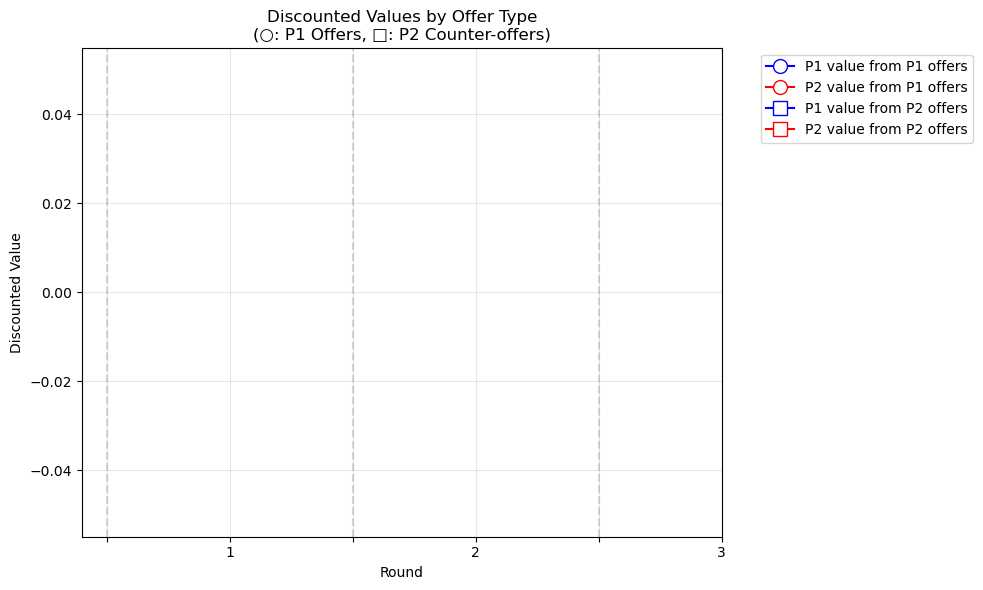

In [14]:
plot_discounted_values(rounds, p1_values, p2_values, max_rounds)


## Offer Evolution Plot

This visualization shows how the distribution of items changes over the negotiation rounds, with a separate subplot for each item type.

### Layout
- Creates a grid of subplots (2 columns)
- One subplot per item type
- For odd number of items, removes unused subplot

### Per Item Subplot
- X-axis: Negotiation rounds
- Y-axis: Number of units offered to P2
- Blue line (○): P1's offers
- Red line (○): P2's counter-offers
- Y-axis range: 0 to maximum units available for that item
- Grid shows valid integer unit values

### Interpretation
- Shows how many units of each item type each player offered to give to P2
- P1's remaining units = total_items - offered_units
- Converging lines suggest agreement being reached
- Diverging lines suggest areas of contention

Number of rounds: 0
Number of P1 offers: 0
Number of P2 offers: 0


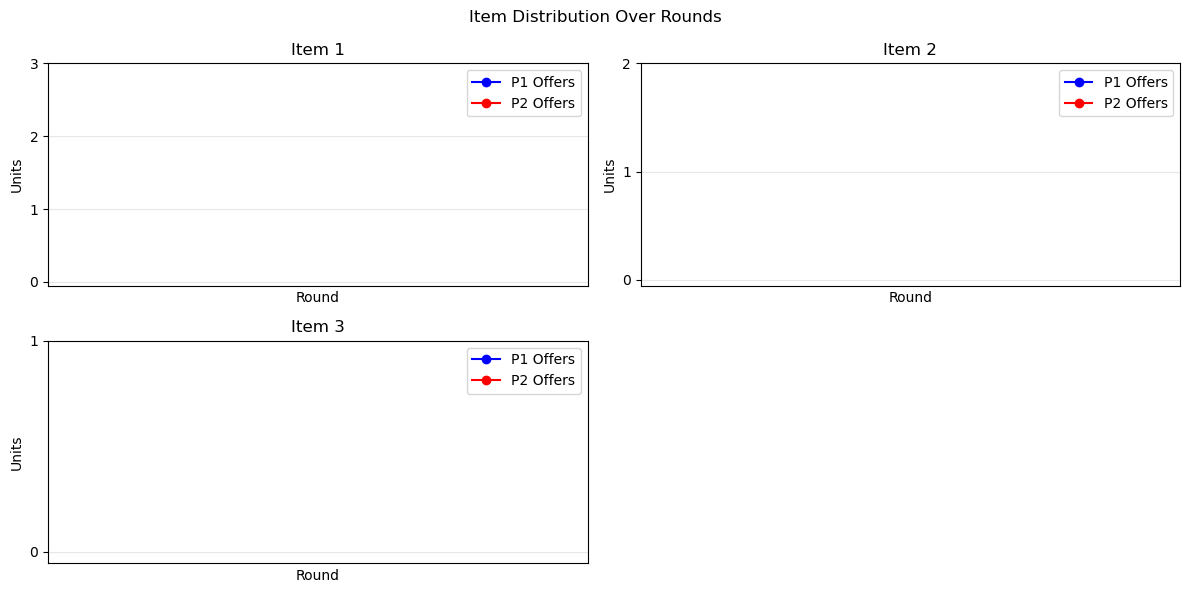

In [15]:
plot_offer_evolution(game, rounds, p1_offers, p2_offers)

In [16]:
def get_final_division(game):
    if game.current_offer: 
        p2_items = game.current_offer.offer  
        p1_items = [t - g for t, g in zip(game.items, p2_items)]  
        return {
            'P1': p1_items,
            'P2': p2_items
        }
    return None
evaluator = GameEvaluator(game)
outside_offer_rational = evaluator.evaluate_outside_offer_consistency()

if game.current_offer:
    final_division = get_final_division(game)
    value_gaps = [abs(p1 - p2) for p1, p2 in zip(p1_values, p2_values)] 
    fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]  

    print("\nBasic Metrics:")
    print(f"Final P1 Value: {p1_values[-1]:.2f}")
    print(f"Final P2 Value: {p2_values[-1]:.2f}")
    print(f"Final Value Gap: {value_gaps[-1]:.2f}")
    print(f"Final Fairness Ratio: {fairness[-1][0]:.2f} : {fairness[-1][1]:.2f}")
    print("\nFinal Division of Items:")
    if final_division:
        print(f"Total Items Available: {game.items}")
        print(f"P1 Received: {final_division['P1']}")
        print(f"P2 Received: {final_division['P2']}")
    else:
        print("No deal reached - no items were divided")

print("\nNegotiation Evaluation:")
print(f"Outside Offer Rational: {'Yes' if outside_offer_rational else 'No'}")

print(f"P1 Valuation of Each Item: {game.player_values[0]}")
print(f"P2 Valuation of Each Item: {game.player_values[1]}")

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Long

## Check Pathologies
- Check if Pathologies Occured
- Check Count in game 
- Save to csv
